In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
# from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import itertools
import warnings
warnings.filterwarnings('ignore')
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

plt.style.use('fivethirtyeight')#drawing style
window=12#Time Window
amount_of_features=60#number of features
d=0.05#dropout coefficient/modulus
batch_size=60#Number of training batches
epoch = 100 #450 #470 #total iterations
output = 12
filename = 'main_ch.csv'
STORAGE_FOLDER = 'FOLDER'
save_file='predict_result_ann.csv'

In [69]:
rainfall_data_matrix = pd.read_csv(filename)
rainfall_data_matrix.drop(rainfall_data_matrix.filter(regex="Unnamed"),axis=1, inplace=True)
rainfall_data_matrix.set_index('THN', inplace=True)
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

THN,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
JAN,NaN,NaN,NaN,NaN,NaN,172.0,63.0,NaN,NaN,NaN,NaN,301.0,148.0,245.0,235.0
FEB,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,NaN,250.0,198.0,189.0,180.0
MAR,NaN,NaN,NaN,NaN,NaN,132.0,NaN,NaN,NaN,NaN,NaN,187.0,290.0,400.0,139.0
APR,NaN,NaN,NaN,NaN,NaN,0.0,NaN,73.0,NaN,NaN,NaN,274.0,331.0,327.0,385.0
MEI,NaN,NaN,NaN,NaN,NaN,31.0,NaN,438.0,NaN,NaN,94.0,115.0,143.0,231.0,209.0
JUN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,154.0,NaN,NaN,211.0,337.0,53.0,191.0,153.0
JUL,NaN,127.0,NaN,NaN,NaN,0.0,NaN,20.0,NaN,NaN,80.0,193.0,185.0,213.0,176.0
AGT,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,NaN,NaN,223.0,130.0,118.0,212.0,209.0
SEP,NaN,NaN,NaN,NaN,NaN,353.0,NaN,66.0,NaN,NaN,194.0,154.0,327.0,205.0,122.0
OKT,NaN,NaN,NaN,NaN,NaN,310.0,NaN,NaN,NaN,NaN,410.0,314.0,215.0,148.0,292.0


In [70]:
dates = pd.date_range(start='2008-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=180, freq='MS')

In [71]:
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix_np = rainfall_data_matrix.interpolate()
rainfall_data_matrix_np

,JAN,FEB,MAR,APR,MEI,JUN,JUL,AGT,SEP,OKT,NOV,DES
THN,,,,,,,,,,,,
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,127.00,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,95.25,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN,NaN,63.50,NaN,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,31.75,NaN,NaN,NaN,NaN,NaN
2013,172.0,248.000000,132.000000,0.00,31.000000,12.0,0.00,5.000000,353.000000,310.0,434.0,476.0
2014,63.0,248.333333,141.166667,36.50,234.500000,83.0,10.00,2.500000,209.500000,330.0,436.4,477.6
2015,110.6,248.666667,150.333333,73.00,438.000000,154.0,20.00,0.000000,66.000000,350.0,438.8,479.2
2016,158.2,249.000000,159.500000,123.25,323.333333,173.0,40.00,74.333333,108.666667,370.0,441.2,480.8


In [72]:
jan_median = rainfall_data_matrix_np["JAN"].median()
rainfall_data_matrix_np['JAN'] = rainfall_data_matrix_np["JAN"].fillna(jan_median)
feb_median = rainfall_data_matrix_np["FEB"].median()
rainfall_data_matrix_np['FEB'] = rainfall_data_matrix_np["FEB"].fillna(feb_median)
mar_median = rainfall_data_matrix_np["MAR"].median()
rainfall_data_matrix_np['MAR'] = rainfall_data_matrix_np["MAR"].fillna(mar_median)
apr_median = rainfall_data_matrix_np["APR"].median()
rainfall_data_matrix_np['APR'] = rainfall_data_matrix_np["APR"].fillna(apr_median)
mei_median = rainfall_data_matrix_np["MEI"].median()
rainfall_data_matrix_np['MEI'] = rainfall_data_matrix_np["MEI"].fillna(mei_median)
jun_median = rainfall_data_matrix_np["JUN"].median()
rainfall_data_matrix_np['JUN'] = rainfall_data_matrix_np["JUN"].fillna(jun_median)
jul_median = rainfall_data_matrix_np["JUN"].median()
rainfall_data_matrix_np['JUL'] = rainfall_data_matrix_np["JUL"].fillna(jul_median)
agt_median = rainfall_data_matrix_np["AGT"].median()
rainfall_data_matrix_np['AGT'] = rainfall_data_matrix_np["AGT"].fillna(agt_median)
sep_median = rainfall_data_matrix_np["SEP"].median()
rainfall_data_matrix_np['SEP'] = rainfall_data_matrix_np["SEP"].fillna(sep_median)
okt_median = rainfall_data_matrix_np["OKT"].median()
rainfall_data_matrix_np['OKT'] = rainfall_data_matrix_np["OKT"].fillna(okt_median)
nov_median = rainfall_data_matrix_np["NOV"].median()
rainfall_data_matrix_np['NOV'] = rainfall_data_matrix_np["NOV"].fillna(nov_median)
des_median = rainfall_data_matrix_np["DES"].median()
rainfall_data_matrix_np['DES'] = rainfall_data_matrix_np["DES"].fillna(des_median)
rainfall_data_matrix_np

,JAN,FEB,MAR,APR,MEI,JUN,JUL,AGT,SEP,OKT,NOV,DES
THN,,,,,,,,,,,,
2008,188.9,248.500000,164.083333,198.625,208.833333,163.5,163.50,124.000000,174.000000,322.0,440.0,478.4
2009,188.9,248.500000,164.083333,198.625,208.833333,163.5,127.00,124.000000,174.000000,322.0,440.0,478.4
2010,188.9,248.500000,164.083333,198.625,208.833333,163.5,95.25,124.000000,174.000000,322.0,440.0,478.4
2011,188.9,248.500000,164.083333,198.625,208.833333,163.5,63.50,124.000000,174.000000,322.0,440.0,478.4
2012,188.9,248.500000,164.083333,198.625,208.833333,163.5,31.75,124.000000,174.000000,322.0,440.0,478.4
2013,172.0,248.000000,132.000000,0.000,31.000000,12.0,0.00,5.000000,353.000000,310.0,434.0,476.0
2014,63.0,248.333333,141.166667,36.500,234.500000,83.0,10.00,2.500000,209.500000,330.0,436.4,477.6
2015,110.6,248.666667,150.333333,73.000,438.000000,154.0,20.00,0.000000,66.000000,350.0,438.8,479.2
2016,158.2,249.000000,159.500000,123.250,323.333333,173.0,40.00,74.333333,108.666667,370.0,441.2,480.8


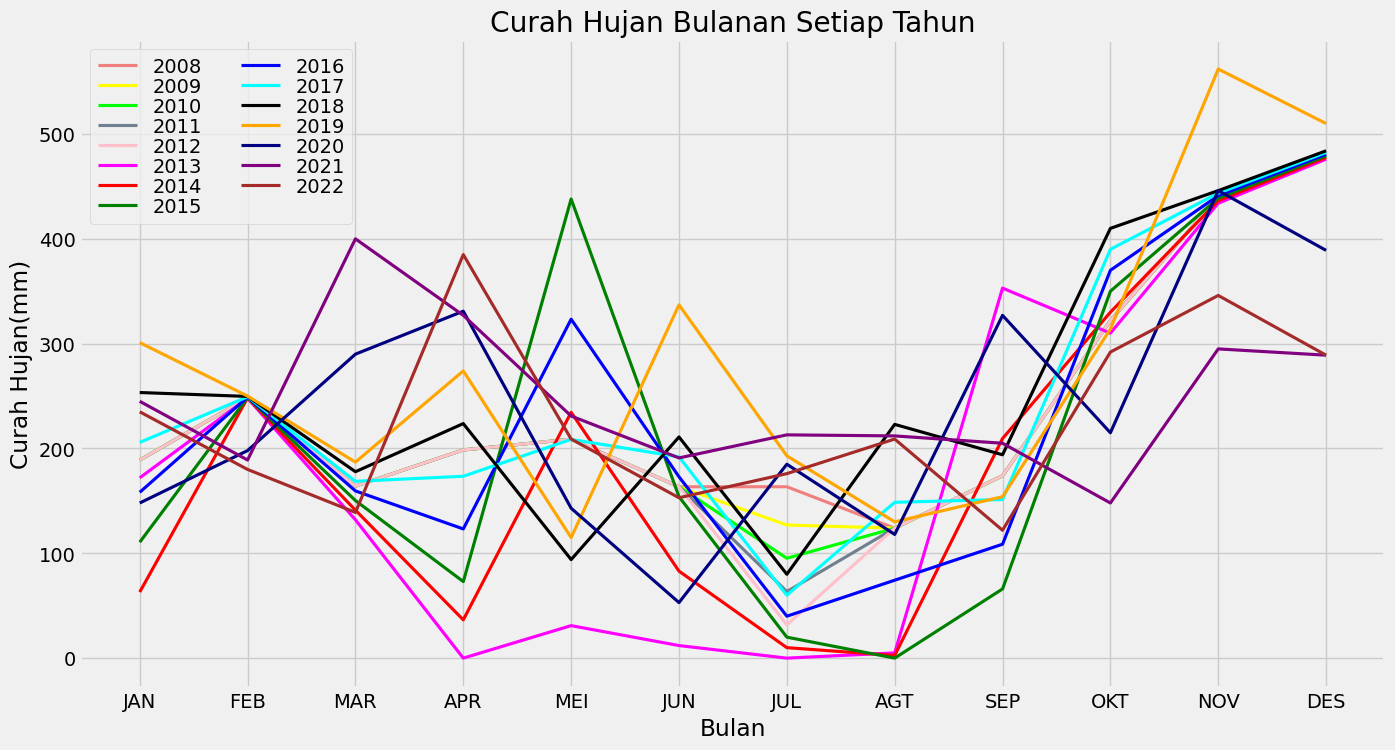

In [73]:
plt.figure(figsize=(15,8))
colors=['lightcoral', 'yellow', 'lime', 'slategray', 'pink', 'magenta', 'red', 'green', 'blue', 'cyan', 'black',
        'orange', 'navy', 'purple', 'brown']
plt.gca().set_prop_cycle(color=colors)
plt.plot(rainfall_data_matrix_np.transpose(), linewidth=2.25)
plt.xlabel('Bulan')
plt.ylabel('Curah Hujan(mm)')
plt.title('Curah Hujan Bulanan Setiap Tahun')
plt.legend(labels=['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019', '2020', '2021', '2022'],
           ncol=2, labelspacing=0.05)

In [74]:
rainfall_data_matrix_np = rainfall_data_matrix_np.to_numpy()
from sklearn.model_selection import train_test_split

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

rainfall_data = rainfall_data.copy()

# apply normalization techniques
for column in rainfall_data.columns:
    min_data = rainfall_data[column].min()
    max_data = rainfall_data[column].max()
    rainfall_data[column] = (rainfall_data[column] - rainfall_data[column].min()) / (rainfall_data[column].max() - rainfall_data[column].min())

test_rainfall_data = rainfall_data.iloc[-24:]
rainfall_data = rainfall_data.iloc[:-24]

rainfall_data


,Precipitation
2008-01-01,0.336121
2008-02-01,0.442171
2008-03-01,0.291963
2008-04-01,0.353425
2008-05-01,0.371590
...,...
2020-08-01,0.209964
2020-09-01,0.581851
2020-10-01,0.382562
2020-11-01,0.793594


In [75]:
#Which column of the data set to choose
data=rainfall_data['Precipitation']

#Construct a dataset for a machine learning model
data=data.values
dataset=data

for i in range(output-1):
    zero=np.zeros(i+1)
    temp=np.append(data[i+1:],zero)
    dataset=np.row_stack((dataset,temp))
dataset=pd.DataFrame(dataset).T
dataset=dataset.iloc[:-(window+window)]
dataset

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.336121,0.442171,0.291963,0.353425,0.371590,0.290925,0.290925,0.220641,0.309609,0.572954,0.782918,0.851246
1,0.442171,0.291963,0.353425,0.371590,0.290925,0.290925,0.220641,0.309609,0.572954,0.782918,0.851246,0.336121
2,0.291963,0.353425,0.371590,0.290925,0.290925,0.220641,0.309609,0.572954,0.782918,0.851246,0.336121,0.442171
3,0.353425,0.371590,0.290925,0.290925,0.220641,0.309609,0.572954,0.782918,0.851246,0.336121,0.442171,0.291963
4,0.371590,0.290925,0.290925,0.220641,0.309609,0.572954,0.782918,0.851246,0.336121,0.442171,0.291963,0.353425
...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.396797,0.345196,0.729537,0.793594,0.861210,0.535587,0.444840,0.332740,0.487544,0.204626,0.599644,0.343416
128,0.345196,0.729537,0.793594,0.861210,0.535587,0.444840,0.332740,0.487544,0.204626,0.599644,0.343416,0.231317
129,0.729537,0.793594,0.861210,0.535587,0.444840,0.332740,0.487544,0.204626,0.599644,0.343416,0.231317,0.274021
130,0.793594,0.861210,0.535587,0.444840,0.332740,0.487544,0.204626,0.599644,0.343416,0.231317,0.274021,0.558719


In [76]:
#Divide Features and Labels
X=dataset.iloc[:,:window]
y=dataset.iloc[:,-output:]
X,y=X.values,y.values
# print(X)

In [77]:
X.shape

(132, 12)

In [78]:
y.shape

(132, 12)

In [81]:
#Build ANN model training
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Dropout
#Build the training model process
model = Sequential()#Build a hierarchical model
model.add(Dense(360,input_dim=window,activation='relu'))#Build the LSTM layer
model.add(Dropout(d))
model.add(Dense(output))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 360)               4680      
                                                                 
 dropout_5 (Dropout)         (None, 360)               0         
                                                                 
 dense_11 (Dense)            (None, 12)                4332      
                                                                 
Total params: 9,012
Trainable params: 9,012
Non-trainable params: 0
_________________________________________________________________


In [82]:
#Neural Network Training and Results
history = model.fit(X, y, epochs =epoch, batch_size = batch_size,verbose=1,validation_split=0.25, shuffle= False) #Training model nb_epoch times

Epoch 1/100
2/2 [==============================] - 1s 107ms/step - loss: 0.2280 - accuracy: 0.0707 - val_loss: 0.2101 - val_accuracy: 0.0909
Epoch 2/100
2/2 [==============================] - 0s 25ms/step - loss: 0.1769 - accuracy: 0.0808 - val_loss: 0.1563 - val_accuracy: 0.0909
Epoch 3/100
2/2 [==============================] - 0s 21ms/step - loss: 0.1353 - accuracy: 0.0808 - val_loss: 0.1136 - val_accuracy: 0.0909
Epoch 4/100
2/2 [==============================] - 0s 20ms/step - loss: 0.1038 - accuracy: 0.0707 - val_loss: 0.0815 - val_accuracy: 0.0909
Epoch 5/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0794 - accuracy: 0.1212 - val_loss: 0.0595 - val_accuracy: 0.0909
Epoch 6/100
2/2 [==============================] - 0s 40ms/step - loss: 0.0627 - accuracy: 0.1212 - val_loss: 0.0465 - val_accuracy: 0.0909
Epoch 7/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0539 - accuracy: 0.1818 - val_loss: 0.0404 - val_accuracy: 0.1212
Epoch 8/100
2/2 [==

In [83]:
# data test (1 tahun terakhir)
test=test_rainfall_data
test=np.reshape(test.values[-12:], (1, window))
#actual forecast testing data (input for next prediction)
predict=model.predict(test)[0,:]
predict

1/1 [==============================] - 0s 35ms/step


array([0.43832508, 0.36511406, 0.26282403, 0.58663464, 0.3799855 ,
       0.28658295, 0.2881822 , 0.3000533 , 0.26807967, 0.5468275 ,
       0.6147884 , 0.46696147], dtype=float32)

In [84]:
predict=np.reshape(predict[:], (1, window))
mse = mean_squared_error(test,  predict)
print(mse)

0.0019981334444793717


In [85]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(test,  predict)
print(mape*100)

9.355357621970567


In [50]:
mae = mean_absolute_error(test,  predict)
print(mae)

0.03405573737861705


In [51]:
rmse = math.sqrt(mse)
print(rmse)

0.039486830315858035


In [86]:
predict = predict * (max_data - min_data) + min_data
predict = predict.astype(int)
print(predict)

[[246 205 147 329 213 161 161 168 150 307 345 262]]


In [30]:
# result = np.array(result)
tahun = 2023
dicthn = {"THN": tahun}
key = ['JAN','FEB','MAR', 'APR', 'MEI', 'JUN', 'JUL', 'AGT', 'SEP', 'OKT', 'NOV', 'DES']
dic = dict(zip(key, predict.flatten()))
dicthn.update(dic)

# dic = dict(enumerate(result.flatten(), 1))
print(dicthn)

{'THN': 2023, 'JAN': 237, 'FEB': 189, 'MAR': 148, 'APR': 374, 'MEI': 218, 'JUN': 160, 'JUL': 170, 'AGT': 188, 'SEP': 129, 'OKT': 297, 'NOV': 330, 'DES': 274}


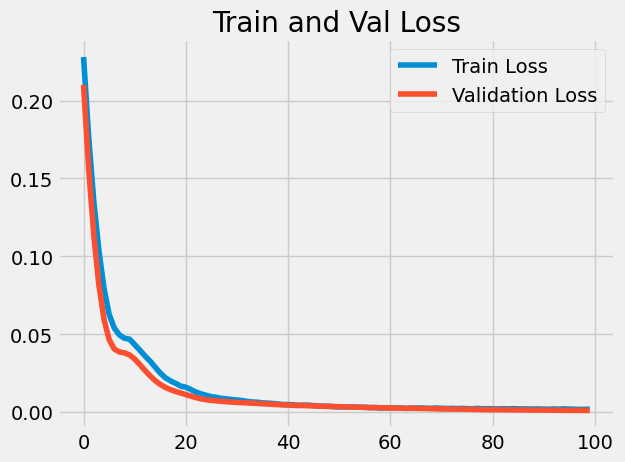

In [87]:
#iterate over images
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

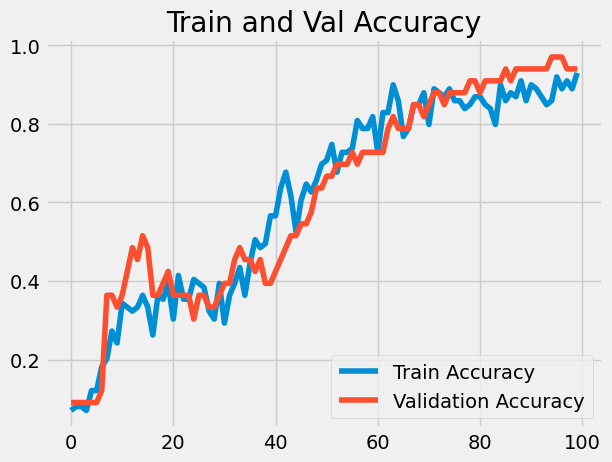

In [88]:
#iterate over images
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Val Accuracy')
plt.show()

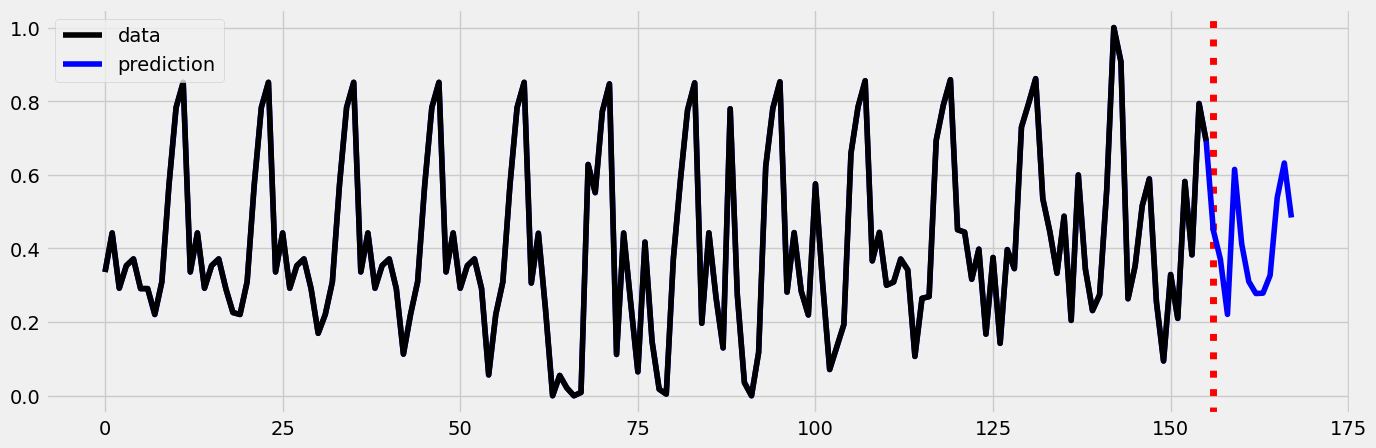

In [89]:
data_times=np.arange(len(data))
all_data=np.hstack((data,result))
predicted_times=np.arange(len(all_data))
plt.figure(figsize=(15, 5))
plt.axvline(len(data), linestyle="dotted", linewidth=5, color='r')
predicted_lines = plt.plot(predicted_times, all_data, label="prediction", color="b")
data_lines = plt.plot(data_times, data, label="data", color="k")
plt.legend(handles=[data_lines[0], predicted_lines[0]],loc="upper left")
#Create separate legends for training, validation, and prediction data
plt.show()

In [90]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)